# 20.440 Project Spring 2024


In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import collections
from IPython.display import clear_output
import random
from scipy.integrate import solve_ivp
from ctypes import DEFAULT_MODE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from permetrics.regression import RegressionMetric
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from mpl_toolkits.mplot3d import Axes3D

#!pip install fastcluster
import fastcluster
from scipy.spatial import distance
from scipy.cluster import hierarchy

import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage

#for polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

#for metrics from JR
#!pip install permetrics
from permetrics.regression import RegressionMetric

#for adaboost regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

#import kmeans library
from sklearn.cluster import KMeans

#for rand index calculation
from itertools import combinations
from collections import Counter
from sklearn.metrics.cluster import rand_score

from scipy.stats import mannwhitneyu
from sklearn.preprocessing import normalize

**Import and trim down files** **bold text**

In [2]:
#import excel data files
#make sure files are uploaded in left folder

#datafiles for dendritic cell, effect of infected with each strain vs when strain not present
df_MODC = pd.read_excel('MODC_infected_vs_noninfected_sorted.xlsx')
#datafiles for bacteria strain, when in media vs when with DC
df_BA = pd.read_excel('bacterial_gene_expression.xlsx')

In [3]:
#Finding genes that have significant log2fold changes in all three strains
thresh_DC = (df_MODC['FDR'] <= 0.05) & (df_MODC['FDR.1'] <= 0.05) & (df_MODC['FDR.2'] <= 0.05)
#finding genes that have an adjusted p-value of less than 0.05 for all three bacterial strains.
thresh_BA=(df_BA['D23580_padj']<=0.05) & (df_BA['LT2_padj']<=0.05) & (df_BA['TY2_padj']<=0.05)
# Taking values from given threshold.
df_MODC_final = df_MODC[thresh_DC]
df_BA_final=df_BA[thresh_BA]

In [4]:
#evaulate number of remaining genes in the matrix
shape(df_MODC_final)
shape(df_BA_final)

print('shape of MODC trimmed: ', shape(df_MODC_final))
print('shabe of bacterial trimmed: ',shape(df_BA_final) )

shape of MODC trimmed:  (3891, 17)
shabe of bacterial trimmed:  (177, 36)


In [5]:
#data sets are decomposed into smaller arrays for multivariate regression
genesDC=df_MODC_final['gene'] #names of DC genes. They are assigned an index that corresponds to the same index in the log2fold change arrays
genesBA=df_BA_final['LT2.GeneName'] #names of bacterial genes. "..."
log2DC_STM23880=df_MODC_final['log2FoldChange'] #log2fold change of DC gene expression after infected with STM23880
log2BA_STM23880=df_BA_final['D23580_log2FoldChange'] #log2fold change of STM23880 gene expression after infecting DC
log2DC_STMLT2=df_MODC_final['log2FoldChange.1'] #log2fold change of DC gene expression after infected with STMLT2
log2BA_STMLT2=df_BA_final['LT2_log2FoldChange'] #log2fold change of STMLT2 gene expression after infecting DC
log2DC_STT2=df_MODC_final['log2FoldChange.2'] #log2fold change of DC gene expression after infected with STT2
log2BA_STT2=df_BA_final['TY2_log2FoldChange'] #log2fold change of STMLT2 gene expression after infecting DC

bacterial genes of biological signficance also found in our filtered data set


-entF [index: 1]

-sufA [index: 43]

-sufB [index: 44]

-mgtC[index: 128]

-mgtB[index: 129]

-bfd[index: 139]

In [6]:
#define input arrays and corresponding output arrays
in_array=np.array([log2DC_STM23880,
                   log2DC_STMLT2,
                   log2DC_STT2])
out_array=np.array([log2BA_STM23880,
                    log2BA_STMLT2,
                    log2BA_STT2])



In [7]:
#fuction for linear regression model. Takes in DC and bacterial gene expression changes, returns the beta matrix (beta) and error vector (y_int)
def lin_reg(in_DC, out_BA):
    clf = linear_model.LinearRegression()
    reg=clf.fit(in_DC,out_BA)
    beta=clf.coef_
    y_int=clf.intercept_
    return(beta,y_int)

##  **Volcano Plots**

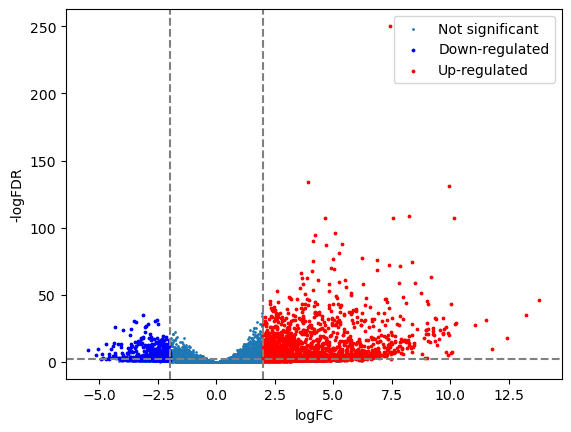

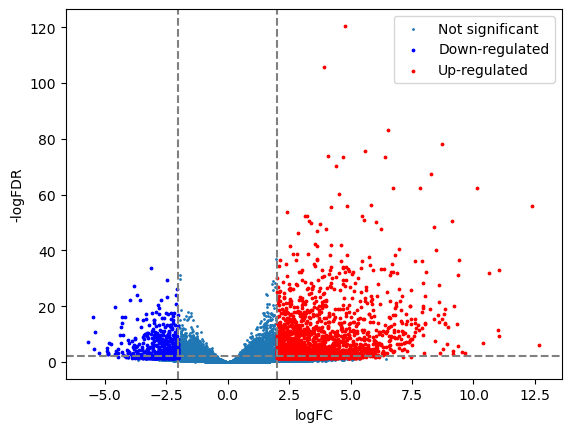

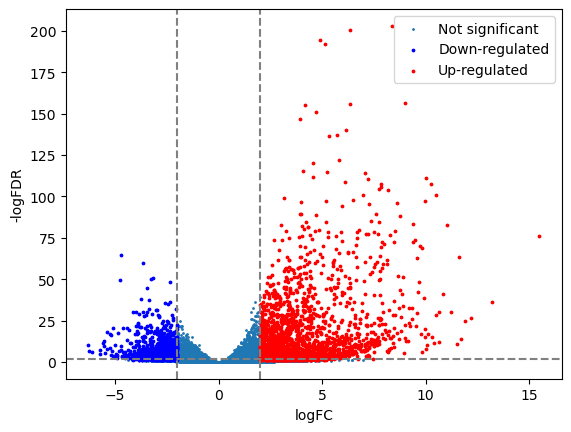

In [8]:
#make volcano plots for dendritic cell genes
FDR_modc_STM_D23380 = df_MODC['FDR']
FDR_modc_STM_LT2 = df_MODC['FDR.1']
FDR_modc_ST_TY2 = df_MODC['FDR.2']

plt.scatter(x=df_MODC['log2FoldChange'],y=FDR_modc_STM_D23380.apply(lambda x:-np.log10(x)),s=1, label = "Not significant")
plt.xlabel('Log2Fold Change')
plt.ylabel('-log(FDR)')

# highlight down- or up- regulated genes
down = df_MODC[(df_MODC['log2FoldChange']<=-2)&(df_MODC['FDR']<=0.05)]
up = df_MODC[(df_MODC['log2FoldChange']>=2)&(df_MODC['FDR']<=0.05)]

plt.scatter(x=down['log2FoldChange'],y=down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

#format figure
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_DC_STM_D23380.png')
plt.show()

#repeat for 2nd strain
plt.scatter(x=df_MODC['log2FoldChange.1'],y=df_MODC['FDR.1'].apply(lambda x:-np.log10(x)),s=1, label = "Not significant")
plt.xlabel('Log2Fold Change')
plt.ylabel('-log(FDR)')

# highlight down- or up- regulated genes
down = df_MODC[(df_MODC['log2FoldChange.1']<=-2)&(df_MODC['FDR.1']<=0.05)]
up = df_MODC[(df_MODC['log2FoldChange.1']>=2)&(df_MODC['FDR.1']<=0.05)]

plt.scatter(x=down['log2FoldChange.1'],y=down['FDR.1'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange.1'],y=up['FDR.1'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_DC_STM_LT2.png')
plt.show()

#repeat for 3rd strain
plt.scatter(x=df_MODC['log2FoldChange.2'],y=df_MODC['FDR.2'].apply(lambda x:-np.log10(x)),s=1, label = "Not significant")
plt.xlabel('Log2Fold Change')
plt.ylabel('-log(FDR)')

# highlight down- or up- regulated genes
down = df_MODC[(df_MODC['log2FoldChange.2']<=-2)&(df_MODC['FDR.2']<=0.05)]
up = df_MODC[(df_MODC['log2FoldChange.2']>=2)&(df_MODC['FDR.2']<=0.05)]

plt.scatter(x=down['log2FoldChange.2'],y=down['FDR.2'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange.2'],y=up['FDR.2'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_DC_ST_TY2.png')
plt.show()

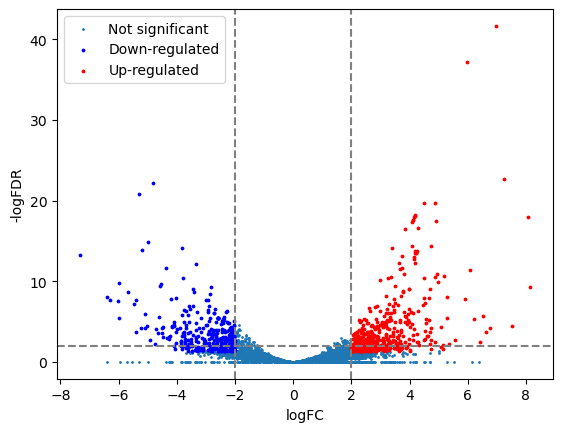

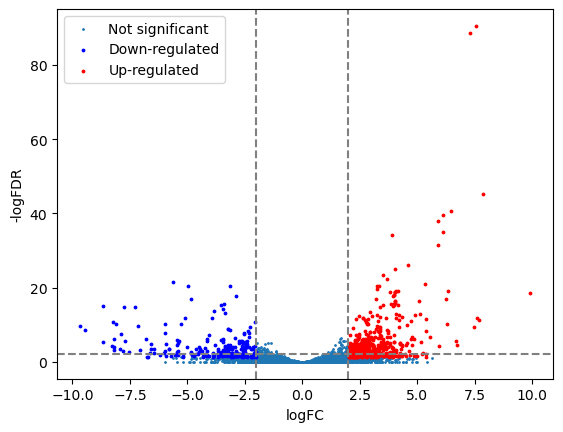

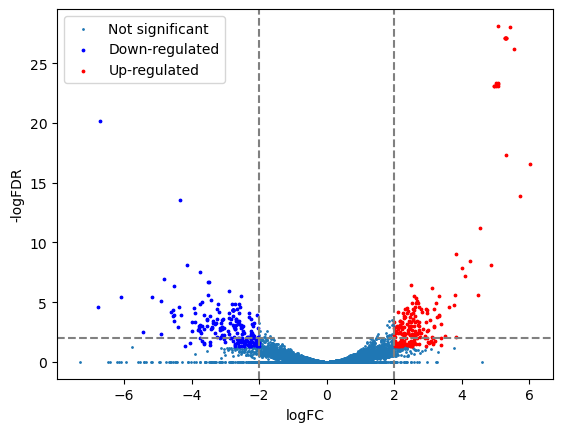

In [9]:
#similar, but now for bacterial genes
FDR_BA_STM_D23380 = df_BA['D23580_padj']

plt.scatter(x=df_BA['D23580_log2FoldChange'],y=FDR_BA_STM_D23380.apply(lambda x:-np.log10(x)),s=1, label = "Not significant")

# highlight down- or up- regulated genes
down = df_BA[(df_BA['D23580_log2FoldChange']<=-2)&(df_BA['D23580_padj']<=0.05)]
up = df_BA[(df_BA['D23580_log2FoldChange']>=2)&(df_BA['D23580_padj']<=0.05)]

plt.scatter(x=down['D23580_log2FoldChange'],y=down['D23580_padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['D23580_log2FoldChange'],y=up['D23580_padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

#format figure
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_BA_STM_D23380.png')
plt.show()

#repeat for 2nd strain
FDR_BA_STM_LT2 = df_BA['LT2_padj']


plt.scatter(x=df_BA['LT2_log2FoldChange'],y=FDR_BA_STM_LT2.apply(lambda x:-np.log10(x)),s=1, label = "Not significant")

# highlight down- or up- regulated genes
down = df_BA[(df_BA['LT2_log2FoldChange']<=-2)&(df_BA['LT2_padj']<=0.05)]
up = df_BA[(df_BA['LT2_log2FoldChange']>=2)&(df_BA['LT2_padj']<=0.05)]

plt.scatter(x=down['LT2_log2FoldChange'],y=down['LT2_padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['LT2_log2FoldChange'],y=up['LT2_padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

#format figure
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_BA_STM_LT2.png')
plt.show()

#repeat for 3rd strain
FDR_BA_ST_TY2 = df_BA['TY2_padj']
plt.scatter(x=df_BA['TY2_log2FoldChange'],y=FDR_BA_ST_TY2.apply(lambda x:-np.log10(x)),s=1, label = "Not significant")

# highlight down- or up- regulated genes
down = df_BA[(df_BA['TY2_log2FoldChange']<=-2)&(df_BA['TY2_padj']<=0.05)]
up = df_BA[(df_BA['TY2_log2FoldChange']>=2)&(df_BA['TY2_padj']<=0.05)]

plt.scatter(x=down['TY2_log2FoldChange'],y=down['TY2_padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['TY2_log2FoldChange'],y=up['TY2_padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

#format figure
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_BA_ST_TY2.png')
plt.show()

# **Similarity MODC and BA genes across strains**


*  MODC

Significance between 0 and 1: p-value = 0.02986675053569634, Indicator = *
Significance between 0 and 2: p-value = 0.3775054069107945, Indicator = 
Significance between 1 and 2: p-value = 0.2163245708053746, Indicator = 


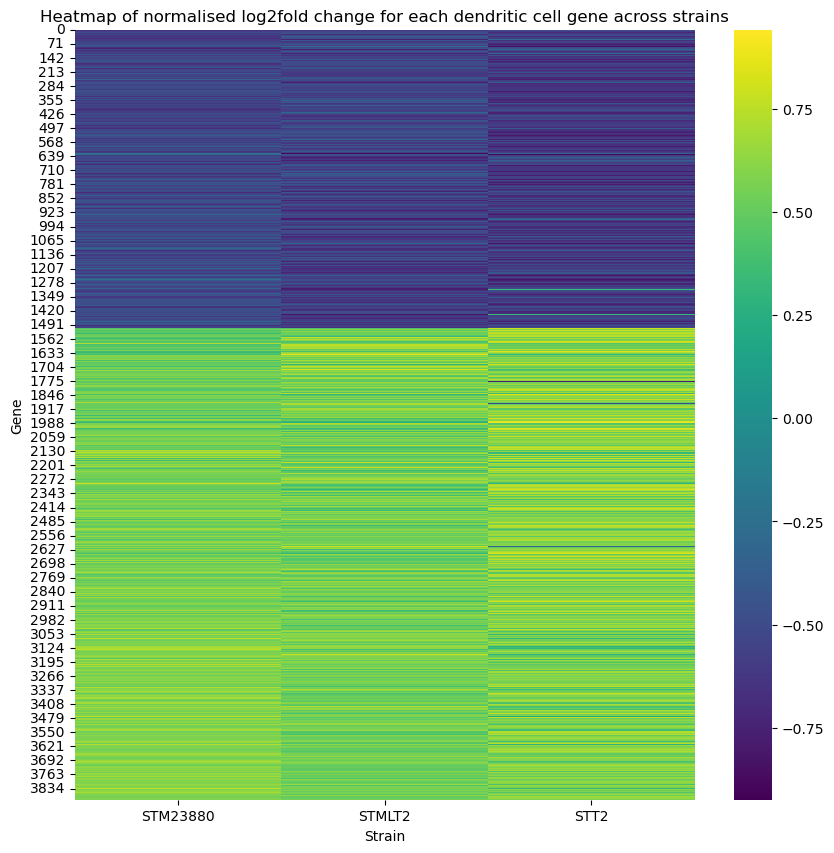

In [10]:
#mann Whitney U test
#combine expression data for dendritic cells
expression_data_MODC = [log2DC_STM23880, log2DC_STMLT2, log2DC_STT2]
# define significance levels and their symbols
significance_levels = [(0.05, '*'), (0.01, '**'), (0.001, '***')]

# calculate significance indicators
def get_significance_indicator(p_value):
    for level, symbol in significance_levels:
        if p_value < level:
            return symbol
    return ''

# calculate significance between each pair of strains
for i in range(len(expression_data_MODC)):
    for j in range(i + 1, len(expression_data_MODC)):
        _, p_value = mannwhitneyu(expression_data_MODC[i], expression_data_MODC[j])
        significance_indicator = get_significance_indicator(p_value)
        print(f"Significance between {i} and {j}: p-value = {p_value}, Indicator = {significance_indicator}")



#combine data into dataframe
expression_data = pd.DataFrame({
    'STM23880': log2DC_STM23880,
    'STMLT2': log2DC_STMLT2,
    'STT2': log2DC_STT2
})

# normalise columns
normalized_expression_data = pd.DataFrame(normalize(expression_data), columns=expression_data.columns)

# heatmap of log2 fold change values for each DC gene across strains
plt.figure(figsize=(10, 10))
sns.heatmap(normalized_expression_data, cmap='viridis')
plt.title('Heatmap of normalised log2fold change for each dendritic cell gene across strains')
plt.xlabel('Strain')
plt.ylabel('Gene')
plt.savefig('heatmap_DC.png')
plt.show()

* BA

In [11]:
#extract data for BA into a single array
expression_data_BA = [log2BA_STM23880, log2BA_STMLT2, log2BA_STT2]


#define significance levels and their symbols
significance_levels = [(0.05, '*'), (0.01, '**'), (0.001, '***')]

#  calculate significance (function)
def get_significance_indicator(p_value):
    for level, symbol in significance_levels:
        if p_value < level:
            return symbol
    return ''

# calculate significance between each pair of strains
for i in range(len(expression_data_BA)):
    for j in range(i + 1, len(expression_data_BA)):
        _, p_value = mannwhitneyu(expression_data_BA[i], expression_data_BA[j])
        significance_indicator = get_significance_indicator(p_value)
        print(f"Significance between {i} and {j}: p-value = {p_value}, Indicator = {significance_indicator}")


Significance between 0 and 1: p-value = 0.5819561629301655, Indicator = 
Significance between 0 and 2: p-value = 0.009814270960555645, Indicator = *
Significance between 1 and 2: p-value = 0.0025223957308862957, Indicator = *


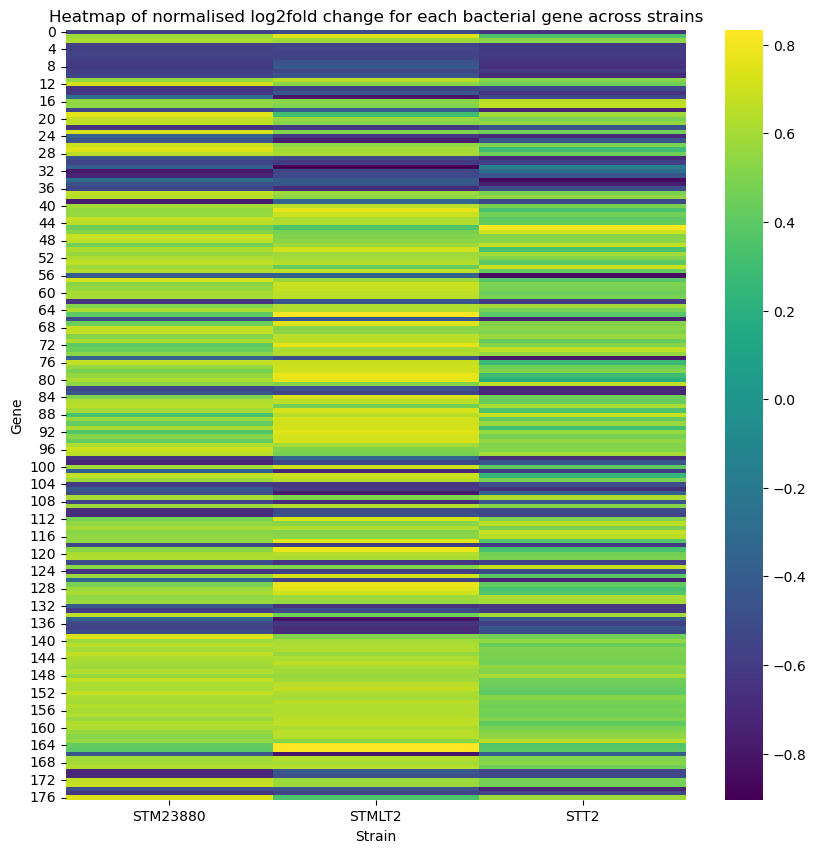

In [12]:
#combine data
expression_data = pd.DataFrame({
    'STM23880': log2BA_STM23880,
    'STMLT2': log2BA_STMLT2,
    'STT2': log2BA_STT2
})

# normalise
normalized_expression_data = pd.DataFrame(normalize(expression_data), columns=expression_data.columns)

# heatmap of log2 fold change values for each DC gene across strains
plt.figure(figsize=(10, 10))
sns.heatmap(normalized_expression_data, cmap='viridis')
plt.title('Heatmap of normalised log2fold change for each bacterial gene across strains')
plt.xlabel('Strain')
plt.ylabel('Gene')
plt.savefig('heatmap_BA.png')
plt.show()

# **Regression models**

**Muliple linear regression**
\begin{equation}
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
=
\begin{bmatrix}
\beta_{11} & \beta_{12} & \cdots & \beta_{1m} \\
\beta_{21} & \beta_{22} & \cdots & \beta_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
\beta_{n1} & \beta_{n2} & \cdots & \beta_{nm}
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_m
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix}
\end{equation}


Here the x vector represents the 1 by 3891 matrix corresponding to the different DC genes and their corresponding log2fold change when infected with a particular strain.(index indicates the gene, value at the index indicates the log2fold change). The y vector represents the log2fold change bacterial genes (index is a specific gene and the value at that index is the log2fold change when bacteria infect a DC). Our first approach was to find the $\beta\$ and \epsilon matrices corresponding to different combinations of our data. The average of these matrices was taken and their performance was assessed using the normalized root mean square error. ***This approach is likely to suffer from overfitting.***

In [13]:
#define input arrays and corresponding output arrays
beta=np.zeros([177,3891,3])
y_int=np.zeros([1,177,3])
y_pred=np.zeros([1,177,3])
error=np.zeros([3])
ind = [
    slice(0, 2),  # index 0 and 1 for training. This corresponds to the strains STM23880 and STMLT2
    slice(1, None),  # index 1 and 2 for training. This corresponds to the strains STMLT2 and STT2
    [0, 2]  # index 0 and 2 for training. This corresponds to strains STM23880 and STT2
]
for j in range(3):
    b,yint=lin_reg(in_array[ind[j],:], out_array[ind[j],:])
    beta[:,:,j]=b
    y_int[:,:,j]=yint
beta_average=(beta[:,:,0]+beta[:,:,1]+beta[:,:,2])/3 #Takes the average of the three generated beta matrices
y_int_average=(y_int[:,:,0]+y_int[:,:,1]+y_int[:,:,2])/3 #Takes the average of the three generated error vectors
#the for loop below evaluates the predicted value of the bacterial gene expression based on the average beta and error matrices
#The normalized root mean squared error between predicted and true values is then calculated.
for u in range(3):
    y_pred[:,:,u]=beta_average@(in_array[u,:].T)+y_int_average
    evaluator = RegressionMetric(out_array[u,:], y_pred[:,:,u].T)
    error[u]=evaluator.normalized_root_mean_square_error()
print(error)

[0.090417   0.10808303 0.14562265]


The second approach for our mutliple linear regression model was to use two of the strains for training and using the left out strain to assess the performance of the model. We did this will all possible combinations.

In [14]:
ind_test=[2,0,1] # ind_test corresponds to the indices that was left out and will be used to test the model performance
beta_2=np.zeros([177,3891,3])
error_linear=[]
diff=np.zeros([3,177])
for p in range(3):
    beta_1,y_int_1=lin_reg(in_array[ind[p],:], out_array[ind[p],:])
    beta_2[:,:,p]=beta_1
    y_pred_1=beta_1@in_array[ind_test[p],:]+y_int_1
    diff[p,:]=np.abs(out_array[ind_test[p],:]- y_pred_1.T)
    evaluator_1= RegressionMetric(out_array[ind_test[p],:], y_pred_1.T)
    err=evaluator_1.normalized_root_mean_square_error()
    error_linear.append(err)

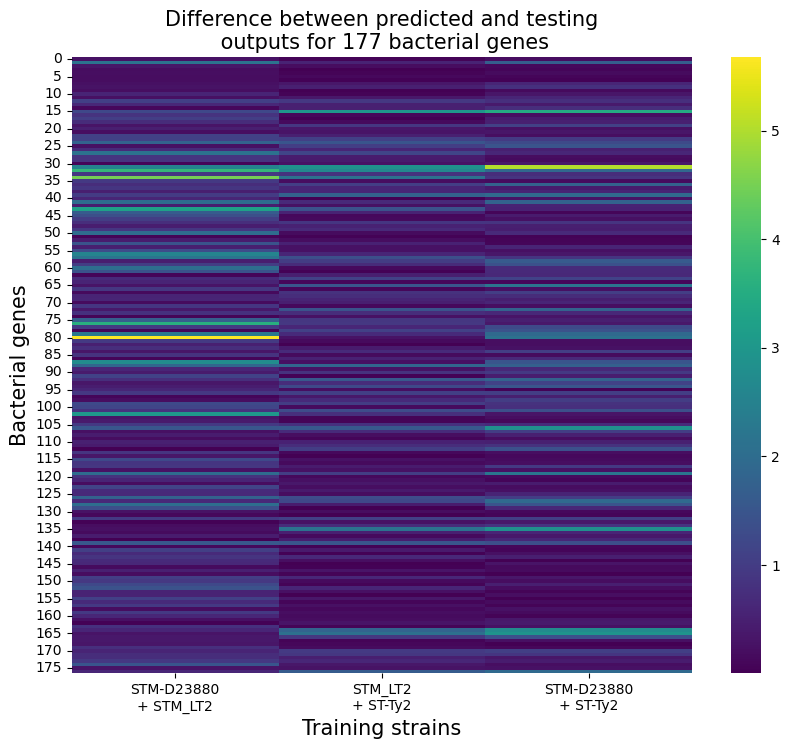

In [15]:
##creating heatmap of the differences between predicted and true bacterial gene expression changes
df_dif=pd.DataFrame(diff.T)
df_dif.columns=['STM-D23880\n+ STM_LT2', 'STM_LT2\n+ ST-Ty2','STM-D23880\n+ ST-Ty2']
##bacterial genes of biological significance (mentioned in the paper) that are also found in our filtered data set
# -entF [index: 1]
# -sufA [index: 43]
# -sufB [index: 44]
# -mgtC[index: 128]
# -mgtB[index: 129]
# -bfd[index: 139]
bacterial_index_bio=[1,43,44, 128, 129, 139]
plt.figure(figsize=(10, 8))
sns.heatmap(df_dif, cmap='viridis')
plt.title('Difference between predicted and testing\n outputs for 177 bacterial genes', fontsize=15)
plt.xlabel('Training strains',fontsize=15)
ylabel('Bacterial genes',fontsize=15)
plt.savefig('Heatmap_bacterial_genes')
dif_bio=np.zeros(3)
bio_true=np.zeros([3,6])
per_err=np.zeros([3,6])
#loops below are meant to calculate differences between predicted and true values, as well as generate array of errors for genes of interest.
for l in range(len(bacterial_index_bio)):
    diff_BA_bio=df_dif.iloc[bacterial_index_bio[l],:]
    for ii in range(3):
        bio_true[ii,l]=out_array[ind_test[ii],l]
        per_err[ii,l]=abs(diff_BA_bio[ii]/bio_true[ii,l])*100
df_err_bio=pd.DataFrame(per_err.T)
df_err_bio.columns=['STM-D23880 + STM_LT2', 'STM_LT2 + ST-Ty2','STM-D23880 + ST-Ty2']
df_err_bio.to_excel('df_err.xlsx')

In [16]:
#function for non linear regression models. Takes in regression model, training, and test data. Returns predicted values and the error
def non_linear_reg(reg_type, Xtrain, Ytrain, Xtest, Ytest):
    clf = reg_type
    multi_output=MultiOutputRegressor(clf) #necessary because training data is 2D
    reg=multi_output.fit(Xtrain, Ytrain)
    pred=multi_output.predict(Xtest)
    evalu=RegressionMetric(Ytest, pred)
    err=evalu.normalized_root_mean_square_error()
    return(pred,err)

In [17]:
#calculating error for the our nonlinear regression models: polynomial, random forest, gradiient boost, ada boost, bagging, and K-nearest neighbor
error_randF=[]
error_GradBoost=[]
error_AdaBoost=[]
error_Bagging=[]
error_KNN=[]
error_poly=[]
for f in range(3):
    X_train = in_array[ind[f],:].reshape(2, -1)
    Y_train = out_array[ind[f],:].reshape(2, -1)
    X_test1=in_array[ind_test[f],:].reshape(1, -1)
    Y_test1=out_array[ind_test[f],:].reshape(1, -1)
    pred_poly, err_poly=non_linear_reg(make_pipeline(PolynomialFeatures(2), LinearRegression()),X_train, Y_train, X_test1, Y_test1)
    error_poly.append(err_poly)
    pred_randF,err_randF=non_linear_reg(RandomForestRegressor(),X_train, Y_train, X_test1, Y_test1)
    error_randF.append(err_randF)
    pred_GradBoost, err_GradBoost=non_linear_reg(GradientBoostingRegressor(random_state=0),X_train, Y_train, X_test1, Y_test1)
    error_GradBoost.append(err_GradBoost)
    pred_AdaBoost, err_AdaBoost=non_linear_reg(AdaBoostRegressor(random_state=0, n_estimators=100),X_train, Y_train, X_test1, Y_test1)
    error_AdaBoost.append(err_AdaBoost)
    pred_Bagging, err_Bagging=non_linear_reg(BaggingRegressor(random_state=0),X_train, Y_train, X_test1, Y_test1)
    error_Bagging.append(err_Bagging)
    pred_KNN, err_KNN=non_linear_reg(KNeighborsRegressor(n_neighbors=2,weights='distance',algorithm='auto'),X_train, Y_train, X_test1, Y_test1)
    error_KNN.append(err_KNN)

**visualisation beta values**

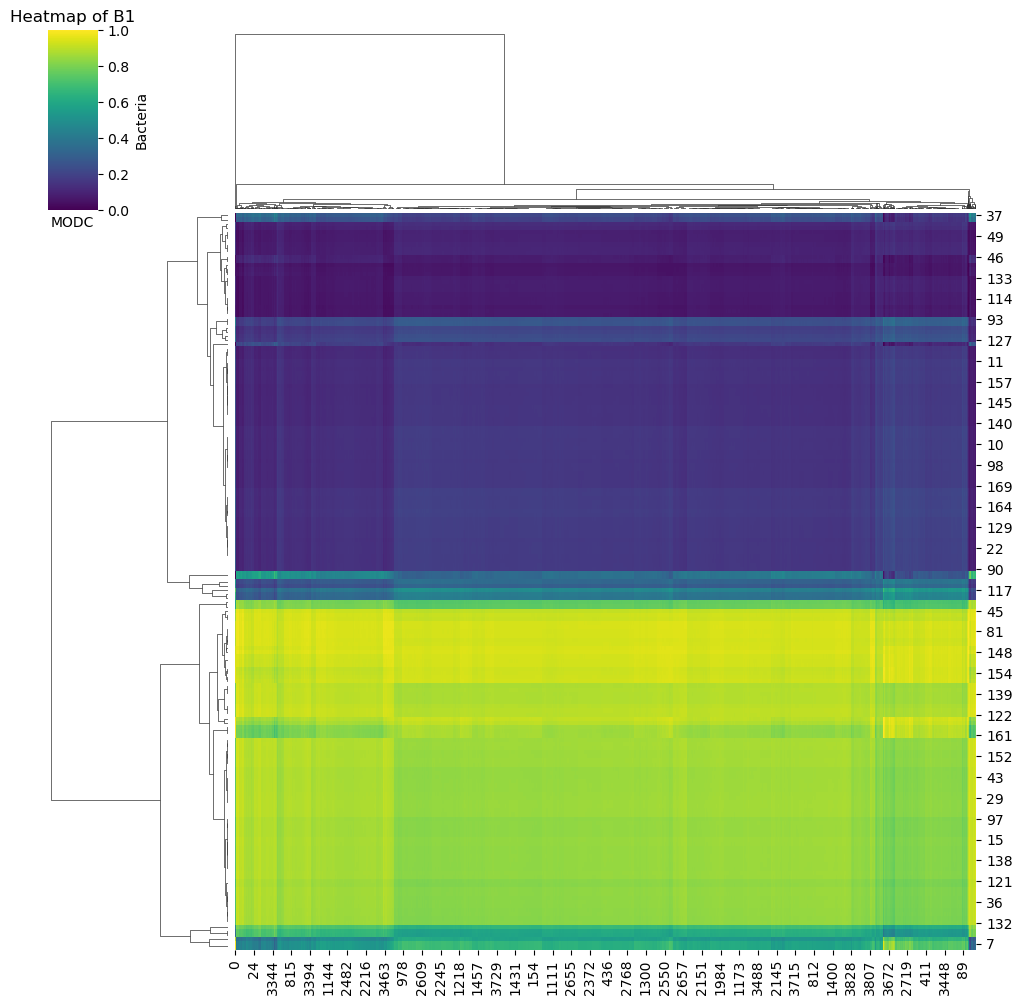

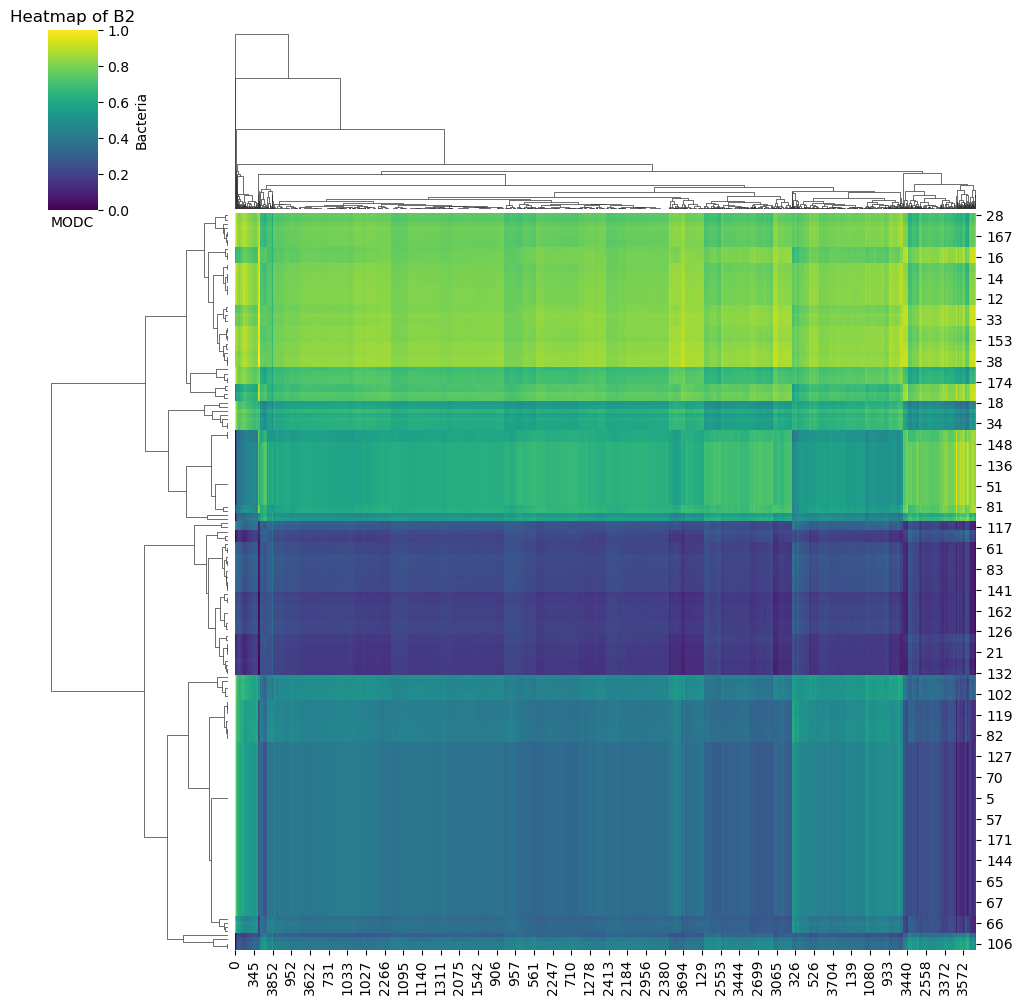

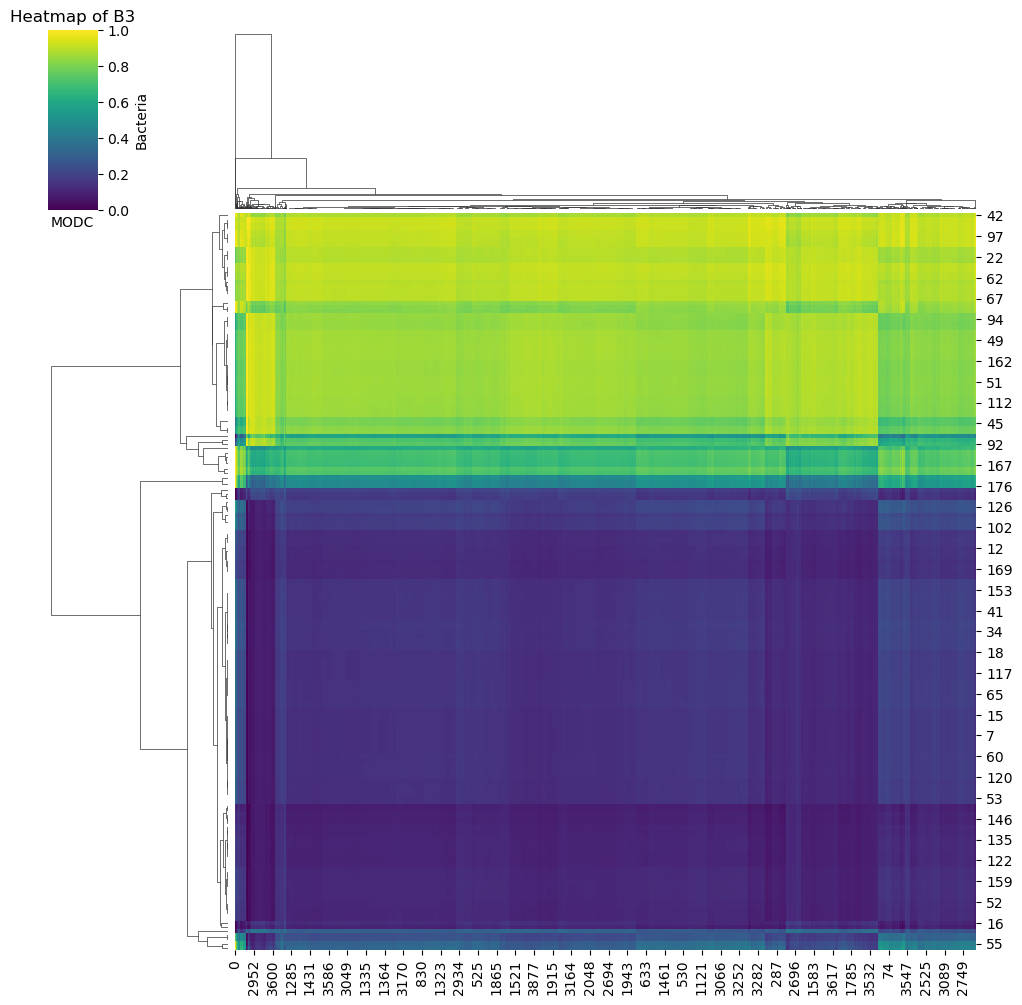

In [18]:
B_val = [beta_2[:,:,0], beta_2[:,:,1], beta_2[:,:,2]]

for idx, B in enumerate(B_val, start=1):
    # standardise across expression of bacteria (rows)
    B_df = pd.DataFrame(B)
    # Transpose the matrix
    B_df_transposed = B_df.T
    # standardise across bacteria (original rows)
    scaler = StandardScaler()
    B_standardized = scaler.fit_transform(B_df_transposed)
    # transpose back
    B_standardized_df = pd.DataFrame(B_standardized.T, columns=B_df.columns)
    #clustering
    clustered_data = sns.clustermap(B_standardized_df,
                                    method='average',
                                    cmap='viridis',
                                    row_cluster=True,
                                    col_cluster=True,
                                    figsize=(10, 10),
                                    standard_scale=0)
    # figure formatting
    plt.xlabel('MODC')
    plt.ylabel('Bacteria')
    plt.title(f'Heatmap of B{idx}')
    plt.savefig(f'Heatmap_B{idx}')
    plt.show()

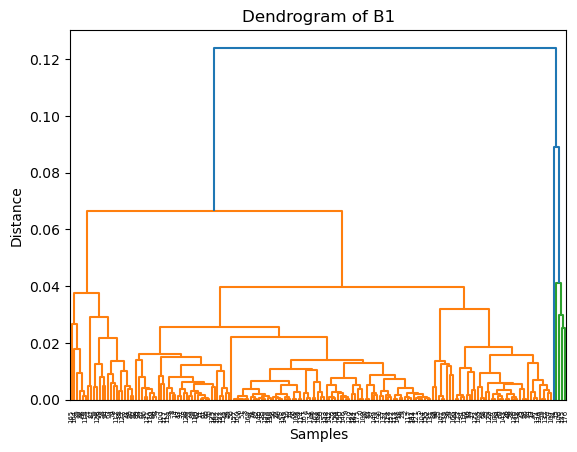

dimensions original data of B{idx}:  (177, 3891)
distance array dimensions of B{idx}:  (15576,)
linkage array dimensions of B{idx}:  (176, 4)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

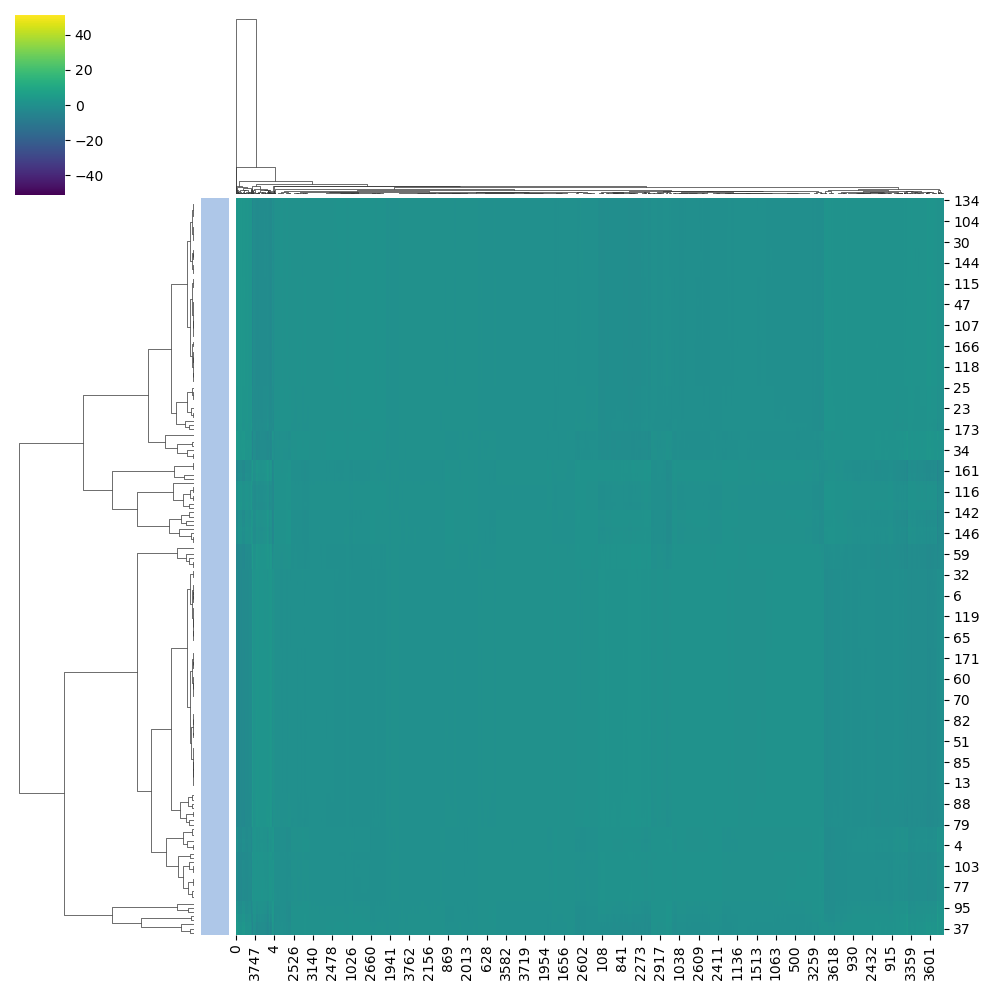

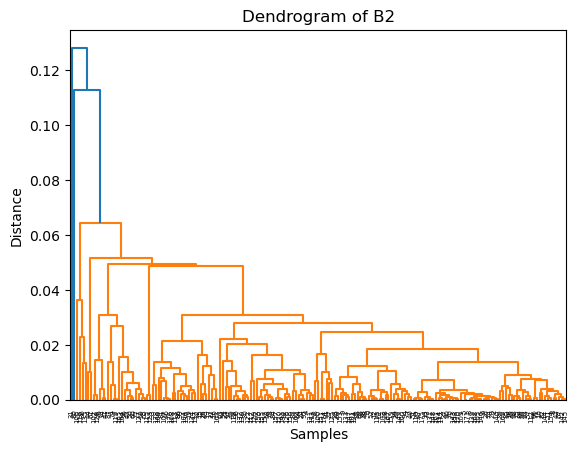

dimensions original data of B{idx}:  (177, 3891)
distance array dimensions of B{idx}:  (15576,)
linkage array dimensions of B{idx}:  (176, 4)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

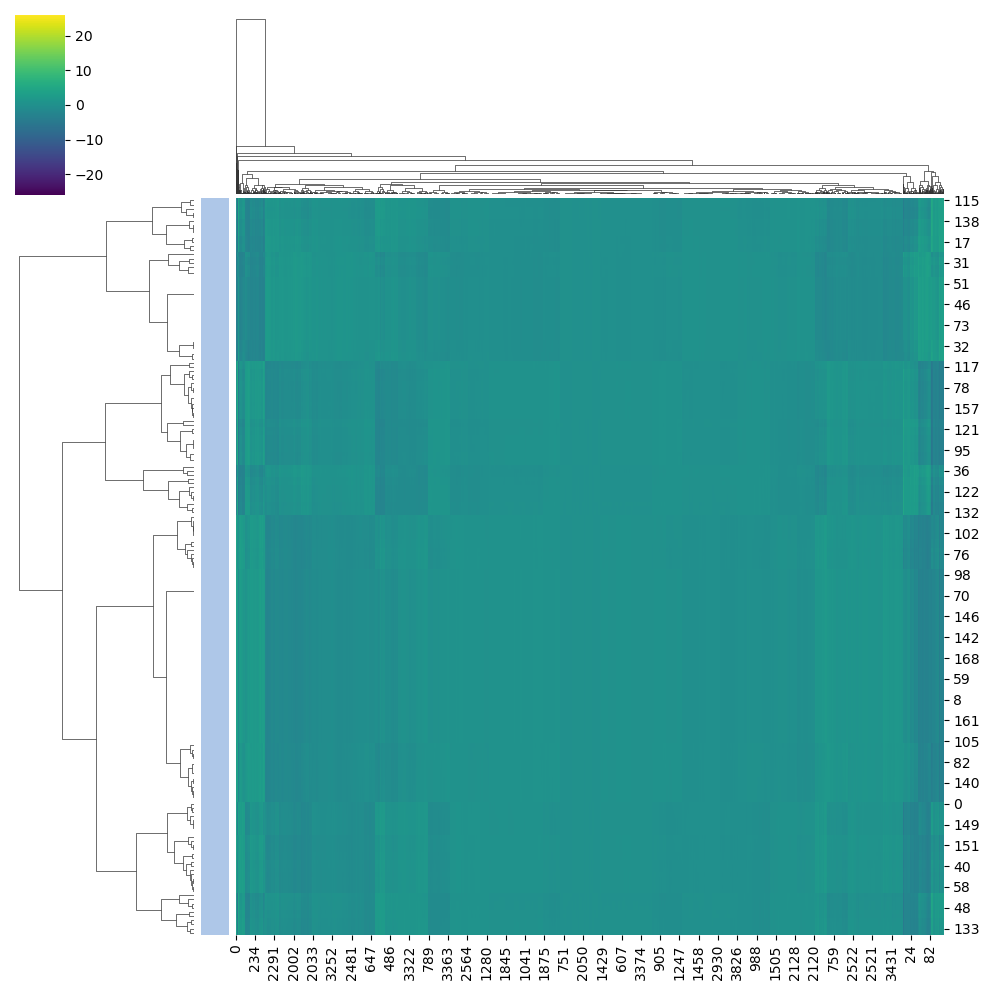

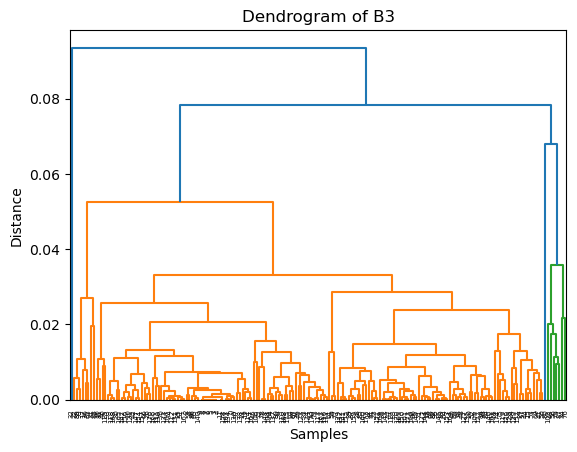

dimensions original data of B{idx}:  (177, 3891)
distance array dimensions of B{idx}:  (15576,)
linkage array dimensions of B{idx}:  (176, 4)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

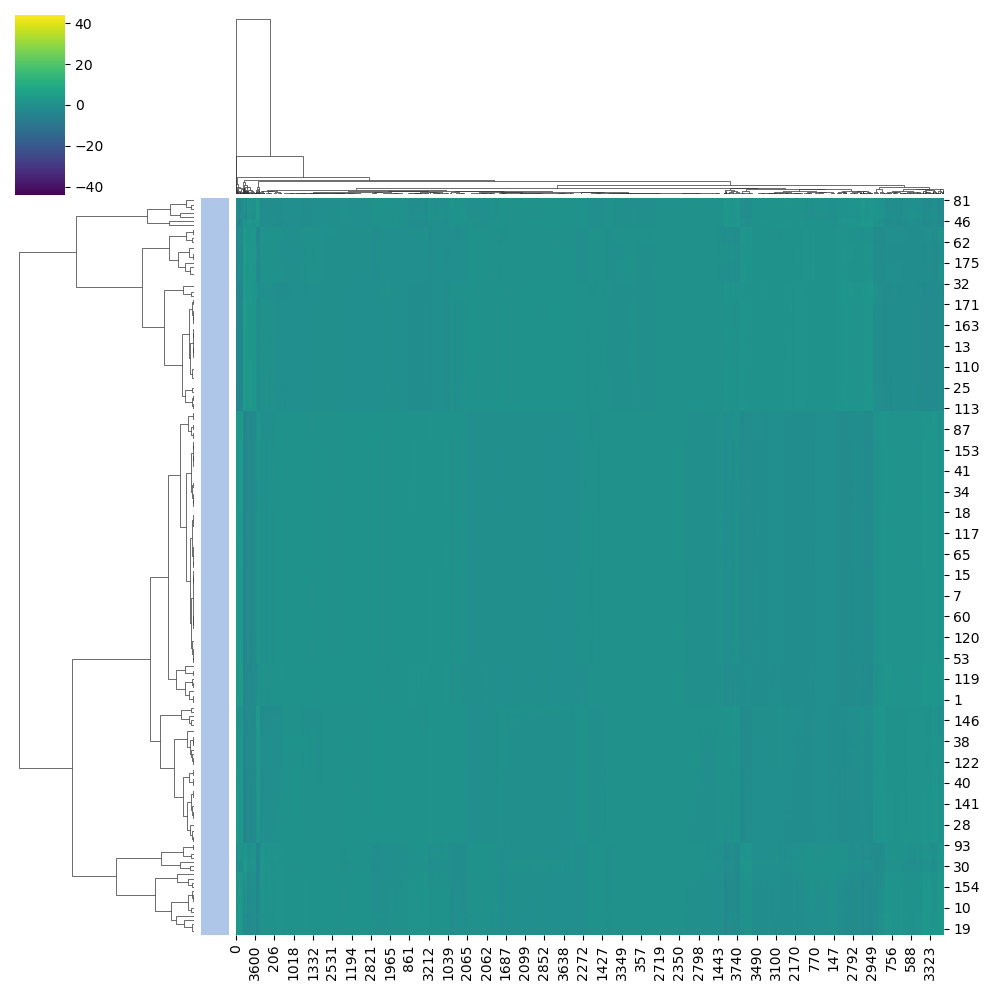

In [19]:
import scipy

for idx, B in enumerate(B_val, start=1): #repeat for all strains
  #standardize across expression of bacteria (eg rows)
  B_df = pd.DataFrame(B)
  #transpose the matrix
  B_df_transposed = B_df.T
  # standardize across bacteria (eg original rows)
  scaler = StandardScaler()
  B_standardized = scaler.fit_transform(B_df_transposed)
  #transpose back
  B_standardized_df= B_standardized.T
  # convert back to DataFrame
  B_standardized_df = pd.DataFrame(B_standardized_df, columns=B_df.columns)
  #calculate distance matrix , euclidean is default
  distance_matrix = distance.pdist(B_df)
  linkage_matrix = hierarchy.linkage(distance_matrix, method = 'average')

  #create a new figure for each dendrogram
  plt.figure()
  #plot dendrogram
  dendrogram = hierarchy.dendrogram(linkage_matrix)
  # figure formatting
  plt.title(f'Dendrogram of B{idx}')
  plt.xlabel('Samples')
  plt.ylabel('Distance')
  plt.show()
  plt.savefig(f'Dendogramandheat_B{idx}')
  #show plot
  plt.show
  print('dimensions original data of B{idx}: ', B_df.shape)
  print('distance array dimensions of B{idx}: ', distance_matrix.shape)
  print('linkage array dimensions of B{idx}: ', linkage_matrix.shape)

  plt.figure()
  #number of colours separated by distance 0.5
  clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, np.abs(0.5),criterion = 'distance')
  clusters_colours = cm.tab20(clusters)
  sns.clustermap(B_standardized_df, cmap='viridis',
  method='average', row_colors = clusters_colours)
  plt.savefig(f'Dendogram_B{idx}')
  plt.show()

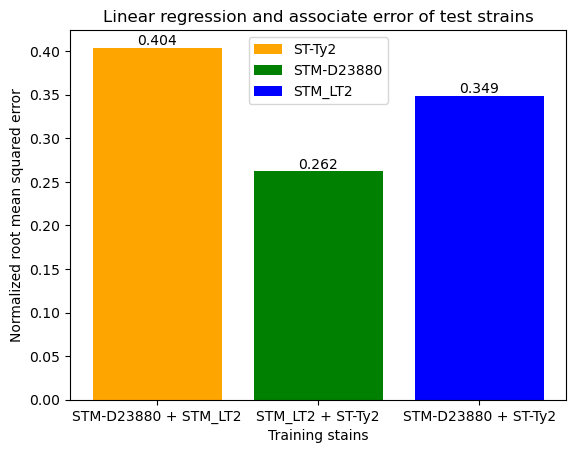

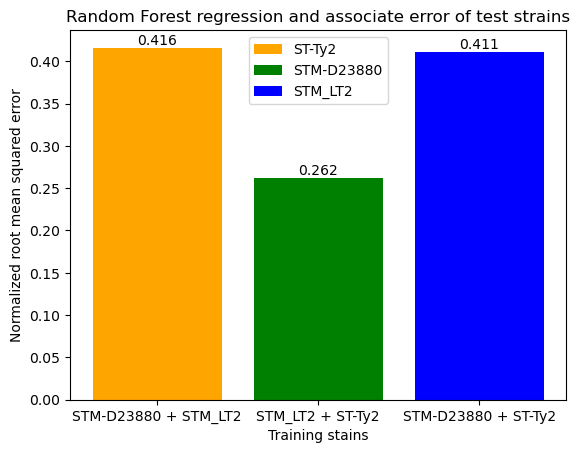

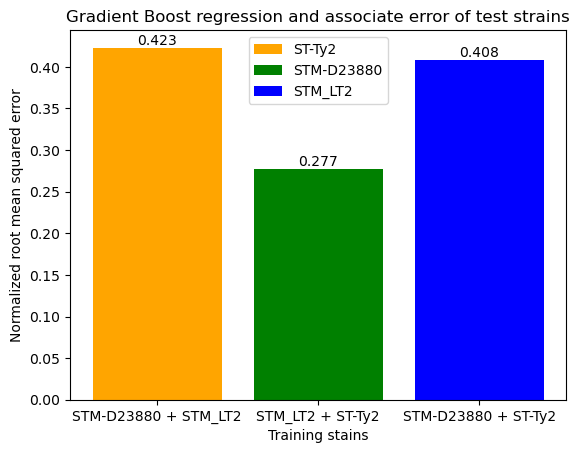

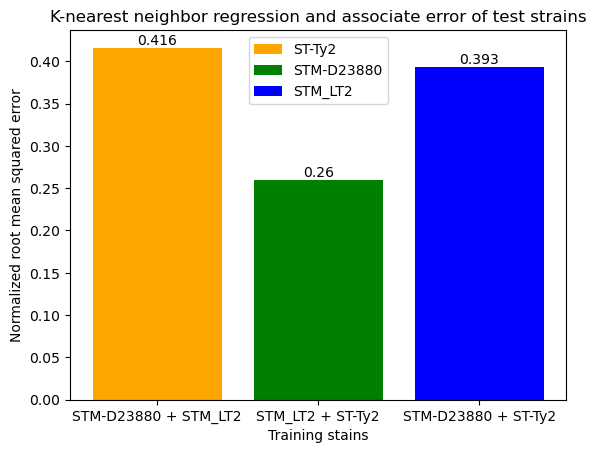

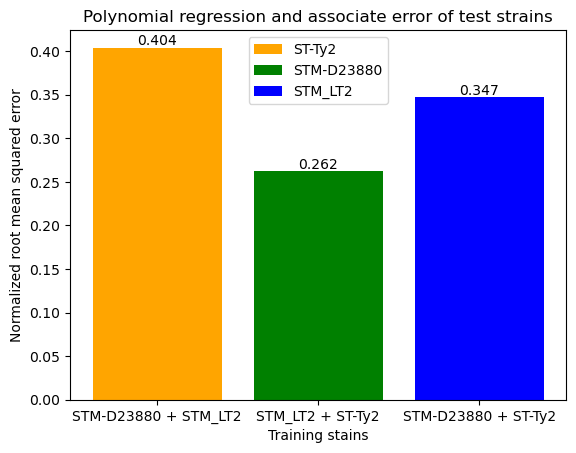

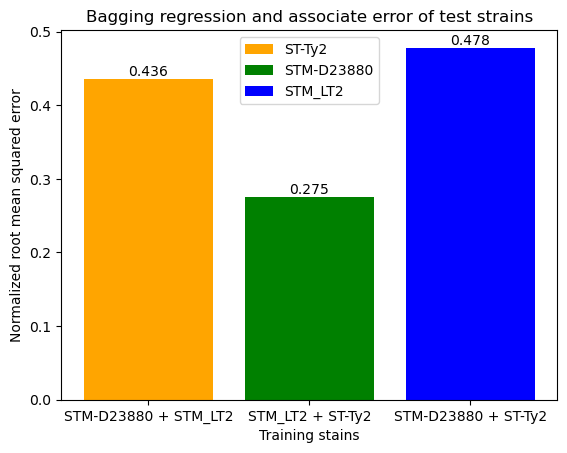

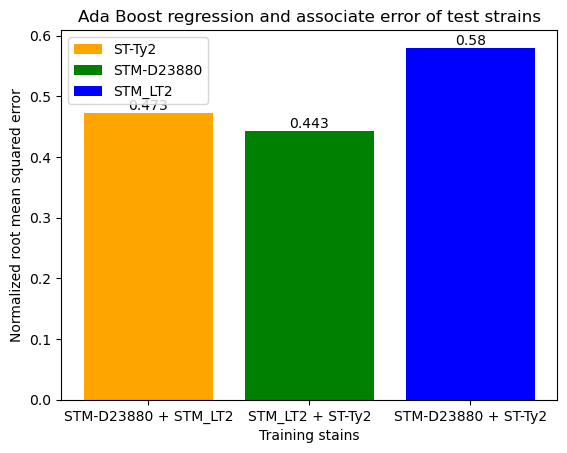

In [20]:
#Bar plots of error associated with each training set and regression type.
x_categories = ['STM-D23880 + STM_LT2', 'STM_LT2 + ST-Ty2','STM-D23880 + ST-Ty2']
y_categories = ['Linear', 'Random Forest','Gradient Boost','K-nearest neighbor','Polynomial','Bagging','Ada Boost']
values = np.round(np.array([error_linear, error_randF,error_GradBoost,error_KNN, error_poly,error_Bagging,error_AdaBoost]),3)
leg=['ST-Ty2','STM-D23880','STM_LT2']
colors = ['orange', 'green', 'blue']
for h in range(7):
    plt.figure(h)
    bars=plt.bar(x_categories, values[h,:],label=leg, color=colors)
    plt.title(y_categories[h]+' regression and associate error of test strains')
    plt.ylabel('Normalized root mean squared error')
    plt.xlabel('Training stains')

    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar
        plt.text(bar.get_x() + bar.get_width()/2, yval,  # Position for the label
                 yval,
                 ha='center', va='bottom')  # Alignment parameters
    plt.legend(loc='best')
    plt.savefig(y_categories[h])
    plt.show()